In [1]:
from scipy.io import wavfile

fs, signal = wavfile.read("/content/LJ050-0275.wav")

print("Sampling Frequency:", fs, "Hz")
print("Signal Shape:", signal.shape)


Sampling Frequency: 22050 Hz
Signal Shape: (201117,)


Original Sampling Frequency: 22050
Final Sampling Frequency Used: 16000


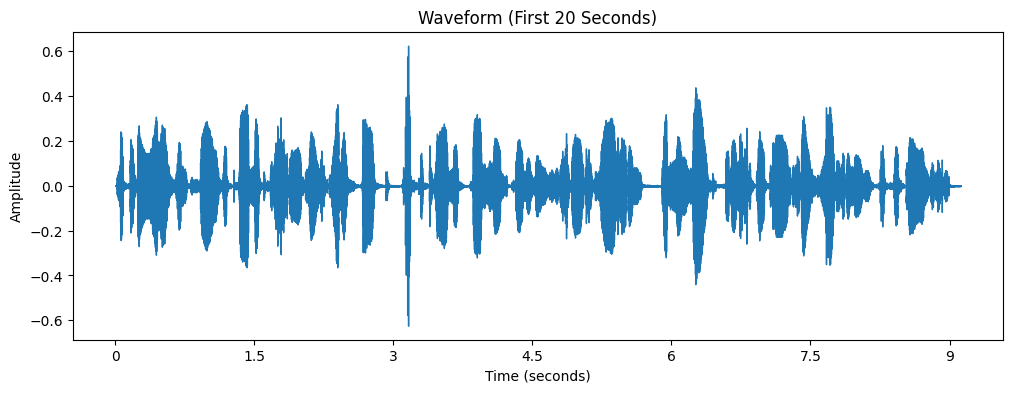

Number of Frames: 910


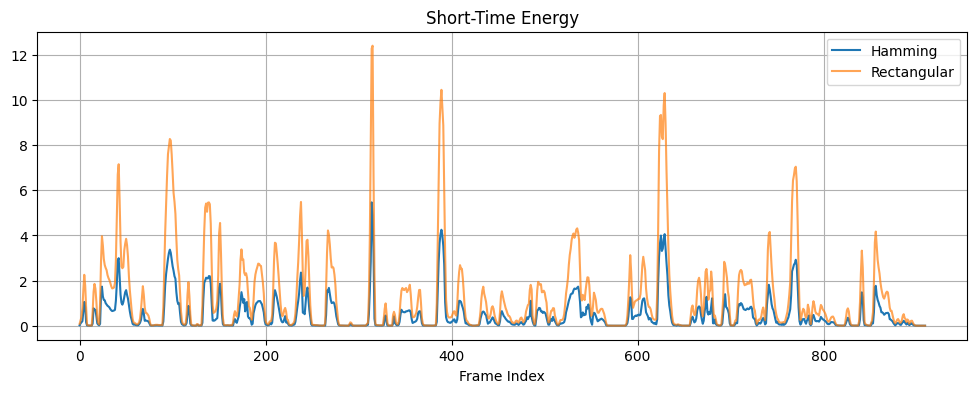

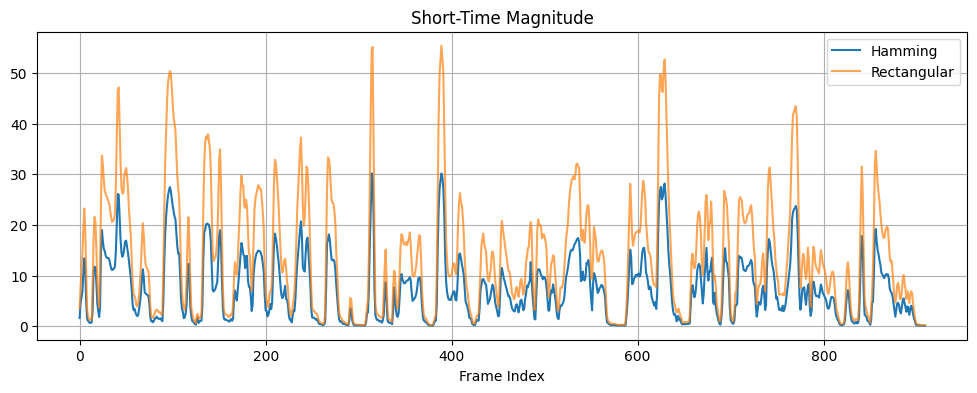

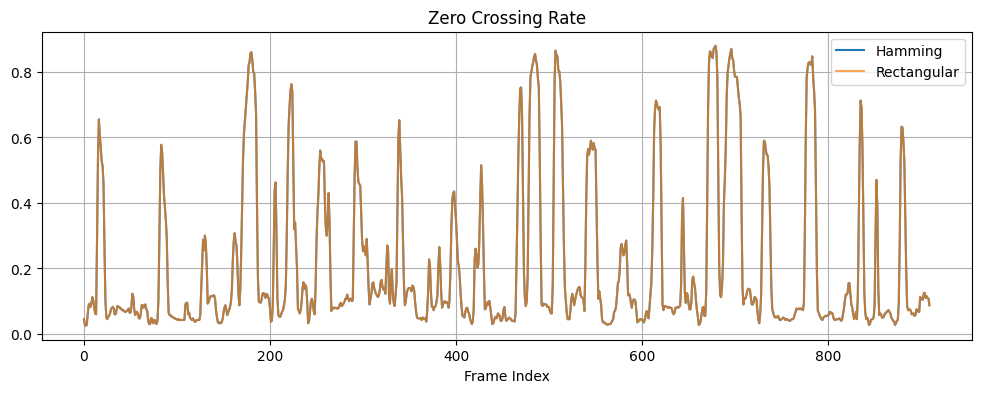

Total Voiced Frames Detected: 888
Estimated Pitch Frequency (Hz) - First 10 Frames:
[242.42424242 222.22222222 219.17808219 219.17808219 228.57142857
 228.57142857 225.35211268 202.53164557 186.04651163 228.57142857]


In [4]:


import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load Speech File

file_path = "/content/LJ050-0275.wav"

# Load with original sampling rate
signal, fs = librosa.load(file_path, sr=None)
print("Original Sampling Frequency:", fs)

# Resample to 16 kHz
if fs != 16000:
    signal = librosa.resample(signal, orig_sr=fs, target_sr=16000)
    fs = 16000

print("Final Sampling Frequency Used:", fs)


# Task 1(a): Plot first 20 seconds

duration = 20 * fs
signal_20s = signal[:duration]

plt.figure(figsize=(12,4))
librosa.display.waveshow(signal_20s, sr=fs)
plt.title("Waveform (First 20 Seconds)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


# Frame Parameters

frame_length = int(0.025 * fs)   # 25 ms
frame_shift = int(0.01 * fs)     # 10 ms
N = len(signal_20s)


# Task 1(b): Number of frames

num_frames = int((N - frame_length) / frame_shift) + 1
print("Number of Frames:", num_frames)


# Task 1(c): Framing Function

def framing(signal, frame_length, frame_shift):
    frames = []
    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        frames.append(signal[start:end])
    return np.array(frames)

frames = framing(signal_20s, frame_length, frame_shift)


# Window Functions

hamming_window = np.hamming(frame_length)
rect_window = np.ones(frame_length)


# Feature Extraction Functions

def short_time_energy(frame):
    return np.sum(frame**2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame))

def autocorr(frame):
    ac = correlate(frame, frame, mode='full')
    return ac[len(ac)//2:]

def amdf(frame):
    N = len(frame)
    return np.array([np.sum(np.abs(frame[:N-l] - frame[l:])) for l in range(N)])

def amsdf(frame):
    N = len(frame)
    return np.array([np.sum((frame[:N-l] - frame[l:])**2) for l in range(N)])


# Task 1(d,e): Feature Extraction

def extract_features(frames, window):
    STE, STM, ZCR = [], [], []
    ACF, AMDF, AMSDF = [], [], []

    for frame in frames:
        frame = frame * window
        STE.append(short_time_energy(frame))
        STM.append(short_time_magnitude(frame))
        ZCR.append(zero_crossing_rate(frame))
        ACF.append(autocorr(frame))
        AMDF.append(amdf(frame))
        AMSDF.append(amsdf(frame))

    return np.array(STE), np.array(STM), np.array(ZCR), ACF, AMDF, AMSDF

# Hamming Window Features
STE_h, STM_h, ZCR_h, ACF_h, AMDF_h, AMSDF_h = extract_features(frames, hamming_window)

# Rectangular Window Features
STE_r, STM_r, ZCR_r, ACF_r, AMDF_r, AMSDF_r = extract_features(frames, rect_window)


# Task 1(f): Plot Features

features = [
    ("Short-Time Energy", STE_h, STE_r),
    ("Short-Time Magnitude", STM_h, STM_r),
    ("Zero Crossing Rate", ZCR_h, ZCR_r)
]

for title, ham, rect in features:
    plt.figure(figsize=(12,4))
    plt.plot(ham, label="Hamming")
    plt.plot(rect, label="Rectangular", alpha=0.7)
    plt.title(title)
    plt.xlabel("Frame Index")
    plt.legend()
    plt.grid()
    plt.show()


# Task 2: Periodicity Detection

voiced_frames = []

for i in range(len(ACF_h)):
    ac = ACF_h[i]

    r0 = ac[0]        # zero-lag (energy)
    ac[0] = 0         # remove zero-lag

    peak = np.max(ac) / r0   # normalized autocorrelation peak

    if peak > 0.3:    # standard voiced threshold
        voiced_frames.append(i)

print("Total Voiced Frames Detected:", len(voiced_frames))




# Task 3: Pitch Estimation
min_lag = int(fs / 400)
max_lag = int(fs / 60)
pitch_freqs = []

for i in voiced_frames:
    ac = ACF_h[i]
    ac[0] = 0

    search_region = ac[min_lag:max_lag]
    lag = np.argmax(search_region) + min_lag

    pitch_freqs.append(fs / lag)

pitch_freqs = np.array(pitch_freqs)

print("Estimated Pitch Frequency (Hz) - First 10 Frames:")
print(pitch_freqs[:10])



If frame has:
• Strong autocorrelation peak (periodic)
→ Voiced
Else
→ Unvoiced